In [78]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset, ELM, device
torch.set_default_dtype(torch.float64)

In [79]:
x_data = np.float64(np.linspace(-15, 15, 600))
# y_data = np.float64(np.sin(x_data) / x_data)
y_data = np.float64(np.sin(x_data) / x_data + np.random.normal(0, 0.05, 600))

In [80]:
dataset = Dataset(x_data, y_data)
trainset, testset = torch.utils.data.random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

activation = nn.Sigmoid()

In [81]:
model = ELM(1, 50, 1).to(device)

V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset[:][0].reshape(1, -1).to(device))
H = torch.concatenate([torch.ones(1, len(trainset)).to(device), V.to(device)], dim=0).T
T = trainset[:][1].reshape(1, -1).T.to(device)
W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

In [82]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
max_train_error = []
min_train_error = []
max_test_error = []
min_test_error = []
num_neurons = 200
a = [5, 10, 50, 100, 500, 1000]
for j in a:
    train_error = []
    test_error = []
    for i in range(10):
        model = ELM(1, j, 1).to(device)
        V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset[:][0].reshape(1, -1).to(device))
        H = torch.concatenate([torch.ones(1, len(trainset)).to(device), V.to(device)], dim=0).T
        T = trainset[:][1].reshape(1, -1).T.to(device)
        W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1) # bez regularyzacji
        # P = torch.linalg.inv(H.T @ H + 1e-3*torch.eye(H.shape[1]).to(device))
        # W2 = P @ H.T @ T.reshape(1, -1, 1)
        model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T
        train_error.append((model(trainset[:][0].clone().detach().reshape(-1, 1).to(device))-trainset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean())
        test_error.append((model(testset[:][0].clone().detach().reshape(-1, 1).to(device))-testset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean())
    max_train_error.append(max(train_error).item())
    min_train_error.append(min(train_error).item())
    max_test_error.append(max(test_error).item())
    min_test_error.append(min(test_error).item())
# ax[0].plot([5*i+5 for i in range(num_neurons)], max_train_error, 'r', label='Błąd maksymalny')
# ax[0].plot([5*i+5 for i in range(num_neurons)], min_train_error, 'b', label='Błąd minimalny')
# ax[0].set_ylabel('Błąd średniokwadratowy zbioru uczącego')
# ax[0].set_xlabel('Liczba neuronów')
# ax[0].set_yscale('log')
# ax[0].grid()
# ax[0].legend(loc='upper right')
# ax[1].plot([5*i+5 for i in range(num_neurons)], max_test_error, 'r', label='Błąd maksymalny')
# ax[1].plot([5*i+5 for i in range(num_neurons)], min_test_error, 'b', label='Błąd minimalny')
# ax[1].set_ylabel('Błąd średniokwadratowy zbioru weryfikującego')
# ax[1].set_xlabel('Liczba neuronów')
# ax[1].set_yscale('log')
# ax[1].grid()
# ax[1].legend(loc='upper right')
# plt.show()
from decimal import Decimal
for i in min_test_error:
    print(f'{Decimal(i):.2e}', end=' & ')

1.16e-2 & 3.00e-3 & 1.89e-3 & 1.87e-3 & 1.87e-3 & 1.87e-3 & 

Train error: 0.0021705681862902483
Test error: 0.0018768756431479627


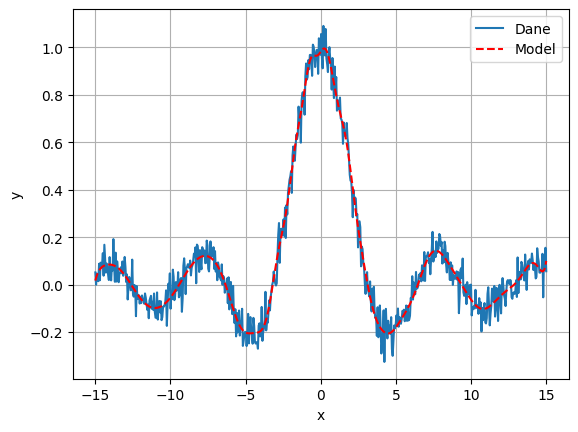

In [83]:
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 1).to(device))-trainset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 1).to(device))-testset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean()}')
plt.plot(x_data, y_data)
plt.plot(x_data, model(torch.tensor(x_data).reshape(-1, 1).to(device)).cpu().detach().numpy(), 'r--')
plt.legend(['Dane', 'Model'], loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

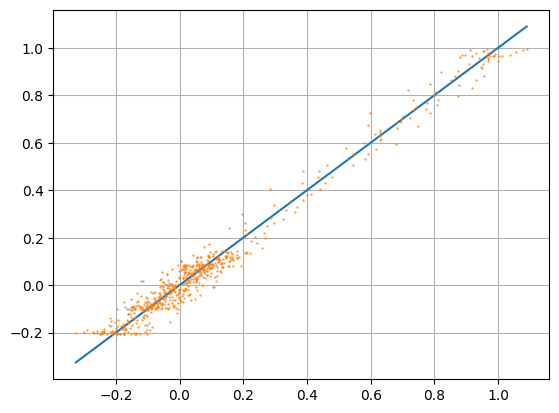

In [84]:
plt.plot([np.min(y_data), np.max(y_data)], [np.min(y_data), np.max(y_data)])
plt.plot(y_data, model(torch.tensor(x_data).reshape(-1, 1).to(device)).cpu().detach().numpy(), '.', markersize=1)
plt.grid()
plt.show()